In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Dropout'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Dropout(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.Dropout(.4),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(.4),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Dropout().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 5057


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1480.21it/s]


Epoch   1/100: RMSE_train: 1,649,623, RMSE_val: 1,372,259


100%|██████████| 646/646 [00:00<00:00, 1761.73it/s]


Epoch   2/100: RMSE_train: 1,095,701, RMSE_val: 1,264,014


100%|██████████| 646/646 [00:00<00:00, 1705.98it/s]


Epoch   3/100: RMSE_train: 989,017, RMSE_val: 1,205,063


100%|██████████| 646/646 [00:00<00:00, 1708.65it/s]


Epoch   4/100: RMSE_train: 968,917, RMSE_val: 1,143,021


100%|██████████| 646/646 [00:00<00:00, 1737.78it/s]


Epoch   5/100: RMSE_train: 943,244, RMSE_val: 1,104,016


100%|██████████| 646/646 [00:00<00:00, 1632.43it/s]


Epoch   6/100: RMSE_train: 922,120, RMSE_val: 1,080,620


100%|██████████| 646/646 [00:00<00:00, 1721.94it/s]


Epoch   7/100: RMSE_train: 922,090, RMSE_val: 1,049,123


100%|██████████| 646/646 [00:00<00:00, 1755.14it/s]


Epoch   8/100: RMSE_train: 917,304, RMSE_val: 1,022,427


100%|██████████| 646/646 [00:00<00:00, 1597.75it/s]


Epoch   9/100: RMSE_train: 909,119, RMSE_val: 997,739


100%|██████████| 646/646 [00:00<00:00, 1525.20it/s]


Epoch  10/100: RMSE_train: 906,809, RMSE_val: 980,025


100%|██████████| 646/646 [00:00<00:00, 1745.35it/s]


Epoch  11/100: RMSE_train: 896,821, RMSE_val: 963,859


100%|██████████| 646/646 [00:00<00:00, 1692.19it/s]


Epoch  12/100: RMSE_train: 902,910, RMSE_val: 950,517


100%|██████████| 646/646 [00:00<00:00, 1593.75it/s]


Epoch  13/100: RMSE_train: 887,697, RMSE_val: 944,283


100%|██████████| 646/646 [00:00<00:00, 1707.76it/s]


Epoch  14/100: RMSE_train: 889,859, RMSE_val: 932,725


100%|██████████| 646/646 [00:00<00:00, 1712.50it/s]


Epoch  15/100: RMSE_train: 888,445, RMSE_val: 926,884


100%|██████████| 646/646 [00:00<00:00, 1731.06it/s]


Epoch  16/100: RMSE_train: 886,616, RMSE_val: 923,412


100%|██████████| 646/646 [00:00<00:00, 1722.96it/s]


Epoch  17/100: RMSE_train: 882,128, RMSE_val: 922,489


100%|██████████| 646/646 [00:00<00:00, 1740.95it/s]


Epoch  18/100: RMSE_train: 880,693, RMSE_val: 918,022


100%|██████████| 646/646 [00:00<00:00, 1734.66it/s]


Epoch  19/100: RMSE_train: 880,813, RMSE_val: 914,194


100%|██████████| 646/646 [00:00<00:00, 1677.31it/s]


Epoch  20/100: RMSE_train: 874,720, RMSE_val: 920,905
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1565.97it/s]


Epoch  21/100: RMSE_train: 871,261, RMSE_val: 970,895
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1773.94it/s]


Epoch  22/100: RMSE_train: 870,176, RMSE_val: 915,686
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1698.64it/s]


Epoch  23/100: RMSE_train: 868,801, RMSE_val: 914,583
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 1602.43it/s]


Epoch  24/100: RMSE_train: 869,554, RMSE_val: 916,904
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1663.37it/s]


Epoch  25/100: RMSE_train: 871,129, RMSE_val: 915,005
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 1493.21it/s]


Epoch  26/100: RMSE_train: 873,730, RMSE_val: 914,400
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 1476.72it/s]


Epoch  27/100: RMSE_train: 868,738, RMSE_val: 919,269
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1744.52it/s]


Epoch  28/100: RMSE_train: 861,476, RMSE_val: 914,499
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1734.77it/s]


Epoch  29/100: RMSE_train: 870,327, RMSE_val: 915,247
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1755.57it/s]


Epoch  30/100: RMSE_train: 876,816, RMSE_val: 929,933
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1515.06it/s]


Epoch  31/100: RMSE_train: 865,103, RMSE_val: 915,944
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 1532.41it/s]


Epoch  32/100: RMSE_train: 861,431, RMSE_val: 920,398
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 1627.82it/s]


Epoch  33/100: RMSE_train: 866,231, RMSE_val: 920,687
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1513.20it/s]


Epoch  34/100: RMSE_train: 862,981, RMSE_val: 916,123
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 1737.96it/s]


Epoch  35/100: RMSE_train: 871,237, RMSE_val: 919,729
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 1612.53it/s]


Epoch  36/100: RMSE_train: 860,731, RMSE_val: 916,898
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 1761.29it/s]


Epoch  37/100: RMSE_train: 853,770, RMSE_val: 921,870
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 1626.35it/s]


Epoch  38/100: RMSE_train: 857,951, RMSE_val: 920,330
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 1754.57it/s]


Epoch  39/100: RMSE_train: 863,504, RMSE_val: 928,101
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1750.75it/s]


Epoch  40/100: RMSE_train: 851,684, RMSE_val: 921,348
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 1688.59it/s]


Epoch  41/100: RMSE_train: 867,889, RMSE_val: 921,106
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 1374.05it/s]


Epoch  42/100: RMSE_train: 864,338, RMSE_val: 918,907
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 1761.65it/s]


Epoch  43/100: RMSE_train: 864,523, RMSE_val: 922,028
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 1752.07it/s]


Epoch  44/100: RMSE_train: 855,655, RMSE_val: 922,704
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 1626.82it/s]


Epoch  45/100: RMSE_train: 856,328, RMSE_val: 936,702
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1738.61it/s]


Epoch  46/100: RMSE_train: 850,938, RMSE_val: 925,189
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 1677.85it/s]


Epoch  47/100: RMSE_train: 847,626, RMSE_val: 932,708
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1710.59it/s]


Epoch  48/100: RMSE_train: 851,458, RMSE_val: 926,417
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 1771.20it/s]


Epoch  49/100: RMSE_train: 856,989, RMSE_val: 927,404
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 1882.08it/s]


Epoch  50/100: RMSE_train: 860,457, RMSE_val: 929,913
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 1844.79it/s]


Epoch  51/100: RMSE_train: 858,338, RMSE_val: 929,539
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1879.24it/s]


Epoch  52/100: RMSE_train: 856,898, RMSE_val: 929,502
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1866.93it/s]


Epoch  53/100: RMSE_train: 846,478, RMSE_val: 926,831
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1883.90it/s]


Epoch  54/100: RMSE_train: 863,575, RMSE_val: 927,409
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1859.70it/s]


Epoch  55/100: RMSE_train: 858,407, RMSE_val: 933,129
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1826.39it/s]


Epoch  56/100: RMSE_train: 847,406, RMSE_val: 929,360
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1839.32it/s]


Epoch  57/100: RMSE_train: 854,600, RMSE_val: 930,620
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 1807.07it/s]


Epoch  58/100: RMSE_train: 848,952, RMSE_val: 935,071
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 1863.23it/s]


Epoch  59/100: RMSE_train: 853,373, RMSE_val: 934,984
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 1849.17it/s]


Epoch  60/100: RMSE_train: 852,480, RMSE_val: 929,331
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 1134.86it/s]


Epoch  61/100: RMSE_train: 854,408, RMSE_val: 932,206
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 1085.75it/s]


Epoch  62/100: RMSE_train: 855,304, RMSE_val: 940,407
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 1666.70it/s]


Epoch  63/100: RMSE_train: 841,668, RMSE_val: 932,843
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 1851.46it/s]


Epoch  64/100: RMSE_train: 853,845, RMSE_val: 932,922
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 1875.97it/s]


Epoch  65/100: RMSE_train: 861,294, RMSE_val: 937,127
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 1905.84it/s]


Epoch  66/100: RMSE_train: 855,372, RMSE_val: 939,810
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 1929.22it/s]


Epoch  67/100: RMSE_train: 850,873, RMSE_val: 933,637
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 1921.41it/s]


Epoch  68/100: RMSE_train: 850,280, RMSE_val: 942,315
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 1951.18it/s]


Epoch  69/100: RMSE_train: 857,979, RMSE_val: 935,880
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 1941.43it/s]


Epoch  70/100: RMSE_train: 856,361, RMSE_val: 936,631
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 1936.85it/s]


Epoch  71/100: RMSE_train: 847,753, RMSE_val: 934,932
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 1954.93it/s]


Epoch  72/100: RMSE_train: 843,792, RMSE_val: 937,697
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 1936.45it/s]


Epoch  73/100: RMSE_train: 843,526, RMSE_val: 935,802
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 1895.91it/s]


Epoch  74/100: RMSE_train: 854,997, RMSE_val: 935,213
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 1904.82it/s]


Epoch  75/100: RMSE_train: 849,165, RMSE_val: 936,314
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 1954.07it/s]


Epoch  76/100: RMSE_train: 851,777, RMSE_val: 936,854
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 1909.42it/s]


Epoch  77/100: RMSE_train: 853,740, RMSE_val: 940,929
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 1950.90it/s]


Epoch  78/100: RMSE_train: 852,925, RMSE_val: 948,466
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 1912.25it/s]


Epoch  79/100: RMSE_train: 848,250, RMSE_val: 940,188
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 1914.06it/s]


Epoch  80/100: RMSE_train: 854,660, RMSE_val: 940,881
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 1968.55it/s]


Epoch  81/100: RMSE_train: 847,777, RMSE_val: 936,884
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 1955.72it/s]


Epoch  82/100: RMSE_train: 861,144, RMSE_val: 939,568
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 1928.04it/s]


Epoch  83/100: RMSE_train: 843,591, RMSE_val: 947,477
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 1972.00it/s]


Epoch  84/100: RMSE_train: 842,350, RMSE_val: 946,649
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 1933.44it/s]


Epoch  85/100: RMSE_train: 849,455, RMSE_val: 944,017
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 1934.22it/s]


Epoch  86/100: RMSE_train: 846,625, RMSE_val: 950,902
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 1900.74it/s]


Epoch  87/100: RMSE_train: 856,399, RMSE_val: 941,087
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 1931.44it/s]


Epoch  88/100: RMSE_train: 844,172, RMSE_val: 942,334
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 1951.73it/s]


Epoch  89/100: RMSE_train: 851,157, RMSE_val: 944,347
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 1955.60it/s]


Epoch  90/100: RMSE_train: 847,387, RMSE_val: 940,502
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 1983.25it/s]


Epoch  91/100: RMSE_train: 852,128, RMSE_val: 1,071,003
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 1943.54it/s]


Epoch  92/100: RMSE_train: 844,561, RMSE_val: 948,584
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 1959.58it/s]


Epoch  93/100: RMSE_train: 845,835, RMSE_val: 946,644
EarlyStopping counter: 74 out of 100


100%|██████████| 646/646 [00:00<00:00, 1933.32it/s]


Epoch  94/100: RMSE_train: 847,677, RMSE_val: 944,151
EarlyStopping counter: 75 out of 100


100%|██████████| 646/646 [00:00<00:00, 1922.37it/s]


Epoch  95/100: RMSE_train: 847,488, RMSE_val: 956,026
EarlyStopping counter: 76 out of 100


100%|██████████| 646/646 [00:00<00:00, 1812.05it/s]


Epoch  96/100: RMSE_train: 851,943, RMSE_val: 947,346
EarlyStopping counter: 77 out of 100


100%|██████████| 646/646 [00:00<00:00, 1814.68it/s]


Epoch  97/100: RMSE_train: 843,029, RMSE_val: 943,885
EarlyStopping counter: 78 out of 100


100%|██████████| 646/646 [00:00<00:00, 1888.79it/s]


Epoch  98/100: RMSE_train: 845,439, RMSE_val: 948,060
EarlyStopping counter: 79 out of 100


100%|██████████| 646/646 [00:00<00:00, 1896.80it/s]


Epoch  99/100: RMSE_train: 843,976, RMSE_val: 949,639
EarlyStopping counter: 80 out of 100


100%|██████████| 646/646 [00:00<00:00, 1912.83it/s]

Epoch 100/100: RMSE_train: 836,955, RMSE_val: 946,946
EarlyStopping counter: 81 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   777544.177  445000.395  0.583  0.612
val     916362.018  506674.737  0.654  0.452
test    927304.669  511298.113  0.630  0.444
--------------------------------------------
total   824105.535  464426.522  0.599  0.563


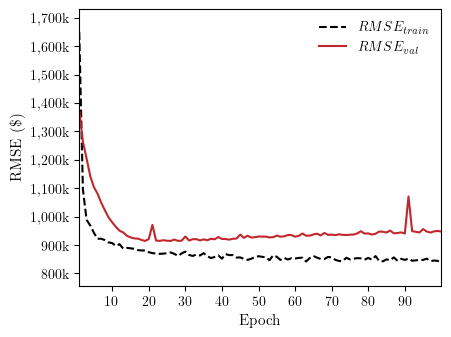

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

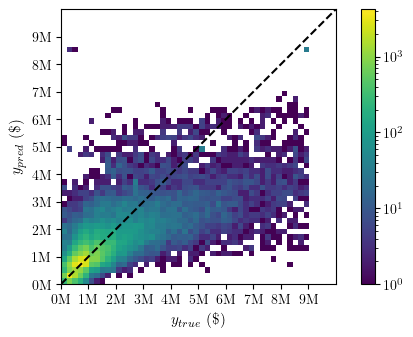

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')